# Import Libraries

In [ ]:
%pip install jax[cpu]
%pip install optax
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
%pip install --upgrade jax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [1]:
# jax
import jax
import numpy as np
import jax.numpy as jnp
from jax import tree_util
import optax

# general
import time
from sklearn import datasets
from matplotlib import pyplot as plt
from google.colab import drive
import pandas as pd

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/augmented_data.csv")

In [4]:
train_df.head()

,pixel0_0,pixel0_1,pixel0_2,pixel0_3,pixel0_4,pixel0_5,pixel0_6,pixel0_7,pixel0_8,pixel0_9,...,pixel63_55,pixel63_56,pixel63_57,pixel63_58,pixel63_59,pixel63_60,pixel63_61,pixel63_62,pixel63_63,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,e


In [5]:
X_train = train_df.drop(['label'], axis=1)
y_train = train_df['label']

In [6]:
val_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/val_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/24-25 Academic Year/CS156/Second Pipeline/0. Dataset/test_data.csv")

In [7]:
X_val = val_df.drop(['label'], axis=1)
y_val = val_df['label']
X_test = test_df.drop(['label'], axis=1)
y_test = test_df['label']

In [8]:
# Model Architecture

def initialize_parameters():
    """
    Initialize the autoencoder parameters with proper scaling.
    Uses He initialization for ReLU layers.
    """
    input_dim = 4096  # 64x64 images
    hidden_dim = 64
    bottleneck_dim = 10
    output_dim = input_dim

    params = {
        "layer_1": {
            "W": np.random.normal(size=(input_dim, hidden_dim)) * np.sqrt(2.0/input_dim),
            "b": np.zeros(shape=(hidden_dim,)),
        },
        "layer_2": {
            "W": np.random.normal(size=(hidden_dim, hidden_dim)) * np.sqrt(2.0/hidden_dim),
            "b": np.zeros(shape=(hidden_dim,)),
        },
        "layer_3": {
            "W": np.random.normal(size=(hidden_dim, bottleneck_dim)) * np.sqrt(2.0/hidden_dim),
            "b": np.zeros(shape=(bottleneck_dim,)),
        },
        "layer_4": {
            "W": np.random.normal(size=(bottleneck_dim, hidden_dim)) * np.sqrt(2.0/bottleneck_dim),
            "b": np.zeros(shape=(hidden_dim,)),
        },
        "layer_5": {
            "W": np.random.normal(size=(hidden_dim, output_dim)) * np.sqrt(2.0/hidden_dim),
            "b": np.zeros(shape=(output_dim,)),
        },
    }
    return params

def predict_fn(params, X):
    """
    Forward pass through the autoencoder.
    Returns both the reconstruction and the bottleneck representation.
    """
    X0 = X
    # Encoder
    X1 = jax.nn.relu(X0 @ params["layer_1"]["W"] + params["layer_1"]["b"])
    X2 = jax.nn.relu(X1 @ params["layer_2"]["W"] + params["layer_2"]["b"])
    X3 = X2 @ params["layer_3"]["W"] + params["layer_3"]["b"]  # Bottleneck layer
    # Decoder
    X4 = jax.nn.relu(X3 @ params["layer_4"]["W"] + params["layer_4"]["b"])
    X5 = jax.nn.sigmoid(X4 @ params["layer_5"]["W"] + params["layer_5"]["b"])
    return {'reconstruct': X5, 'bottleneck': X3}

def loss_fn(params, X):
    """
    Binary cross-entropy loss with numerical stability improvements.
    """
    reconstruct_X = predict_fn(params, X)['reconstruct']
    eps = 1e-7  # Small constant for numerical stability
    reconstruct_X = jnp.clip(reconstruct_X, eps, 1 - eps)
    loss = -(X * jnp.log(reconstruct_X) + (1 - X) * jnp.log(1 - reconstruct_X))
    return jnp.mean(loss)

def train_autoencoder(X_train, X_val, params, num_epochs=100, batch_size=32, learning_rate=1e-3):
    """
    Training loop with validation monitoring and early stopping.
    """
    # Initialize optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    # Prepare for training
    grad_loss_fn = jax.grad(loss_fn)
    grad_loss_fn = jax.jit(grad_loss_fn)

    # Training monitoring
    best_val_loss = float('inf')
    best_params = None
    train_losses = []
    val_losses = []

    for i in range(num_epochs):
        # Get random batch
        idxs = np.random.randint(low=0, high=X_train.shape[0], size=batch_size)
        x_batch = X_train[idxs]

        # Compute gradients and update parameters
        grad = grad_loss_fn(params, x_batch)
        update, opt_state = optimizer.update(grad, opt_state)
        params = optax.apply_updates(params, update)

        # Monitor progress every 100 steps
        if i % 100 == 0:
            train_loss = loss_fn(params, X_train)
            val_loss = loss_fn(params, X_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Step: {i}")
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = jax.tree_map(lambda x: x.copy(), params)

    return best_params, train_losses, val_losses

def visualize_results(params, X_train, X_val, X_test, num_examples=10):
    """
    Create visualization of reconstruction results from all three datasets.
    For each dataset, shows original images on top and their reconstructions below.
    """

    # Each set will have 2 rows (original and reconstruction) and num_examples columns
    fig, axes = plt.subplots(6, num_examples, figsize=(20, 15))
    titles = ['Training', 'Validation', 'Test']
    datasets = [X_train, X_val, X_test]

    for dataset_idx, (title, data) in enumerate(zip(titles, datasets)):
        # Each dataset gets 2 rows: originals (row 0) and reconstructions (row 1)
        row_orig = dataset_idx * 2
        row_recon = row_orig + 1

        plt.text(-0.5, (row_orig + 0.5), title,
                rotation=90, fontsize=14, va='center',
                transform=axes[row_orig, 0].transData)

        # Generate random indices for this dataset
        example_indices = np.random.randint(0, len(data), size=num_examples)

        for col, idx in enumerate(example_indices):
            # Get original image and its reconstruction
            original = data[idx]
            reconstructed = predict_fn(params, original.reshape(1, -1))['reconstruct'][0]

            # Plot original image on top row
            axes[row_orig, col].imshow(original.reshape(64, 64), cmap='Greys')
            axes[row_orig, col].axis('off')
            if col == 0:
                axes[row_orig, col].set_title('Original', pad=10)

            # Plot reconstruction on bottom row
            axes[row_recon, col].imshow(reconstructed.reshape(64, 64), cmap='Greys')
            axes[row_recon, col].axis('off')
            if col == 0:
                axes[row_recon, col].set_title('Reconstructed', pad=10)

        # Add a bit of space between datasets
        if dataset_idx < 2:
            for col in range(num_examples):
                axes[row_recon, col].set_title('_' * 20, pad=10)

    plt.tight_layout(rect=[0.02, 0, 1, 0.95])
    plt.suptitle('Autoencoder Reconstructions\nOriginal vs Reconstructed Images',
                fontsize=16, y=0.98)

    plt.show()

def plot_training_history(train_losses, val_losses):
    """
    Plot training and validation loss curves.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs (x100)')
    plt.ylabel('Loss')
    plt.title('Training History (Bottleneck = 10) and 1000 epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def main(X_train, X_val, X_test):
    # Prepare data
    X_train, X_val, X_test = X_train.to_numpy(), X_val.to_numpy(), X_test.to_numpy()

    # Initialize model
    params = initialize_parameters()

    start_train = time.time()
    # Train model
    best_params, train_losses, val_losses = train_autoencoder(
        X_train,
        X_val,
        params,
        num_epochs=1000,
        batch_size=32,
        learning_rate=1e-3
    )
    end_train = time.time()
    print(f"Training time: {end_train - start_train} seconds")

    # Evaluate on test set
    start_test_time = time.time()
    test_loss = loss_fn(best_params, X_test)
    end_test_time = time.time()
    print(f"\nFinal Test Loss: {test_loss:.4f}")
    print(f"Test time: {end_test_time - start_test_time} seconds")

    # Visualize results
    visualize_results(best_params, X_train, X_val, X_test)
    plot_training_history(train_losses, val_losses)

Step: 0
Training Loss: 0.7107
Validation Loss: 0.7119


<ipython-input-8-fdefcb282d04>:104: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 100
Training Loss: 0.3116
Validation Loss: 0.2849


<ipython-input-8-fdefcb282d04>:104: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 200
Training Loss: 0.2832
Validation Loss: 0.2471


<ipython-input-8-fdefcb282d04>:104: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 300
Training Loss: 0.2662
Validation Loss: 0.2296


<ipython-input-8-fdefcb282d04>:104: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 400
Training Loss: 0.2528
Validation Loss: 0.2139


<ipython-input-8-fdefcb282d04>:104: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 500
Training Loss: 0.2427
Validation Loss: 0.2063


<ipython-input-8-fdefcb282d04>:104: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 600
Training Loss: 0.2331
Validation Loss: 0.1991


<ipython-input-8-fdefcb282d04>:104: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 700
Training Loss: 0.2246
Validation Loss: 0.1901


<ipython-input-8-fdefcb282d04>:104: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 800
Training Loss: 0.2187
Validation Loss: 0.1839


<ipython-input-8-fdefcb282d04>:104: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 900
Training Loss: 0.2140
Validation Loss: 0.1791


<ipython-input-8-fdefcb282d04>:104: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Training time: 51.184436559677124 seconds

Final Test Loss: 0.1787
Test time: 0.01601409912109375 seconds


<ipython-input-8-fdefcb282d04>:153: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0.02, 0, 1, 0.95])


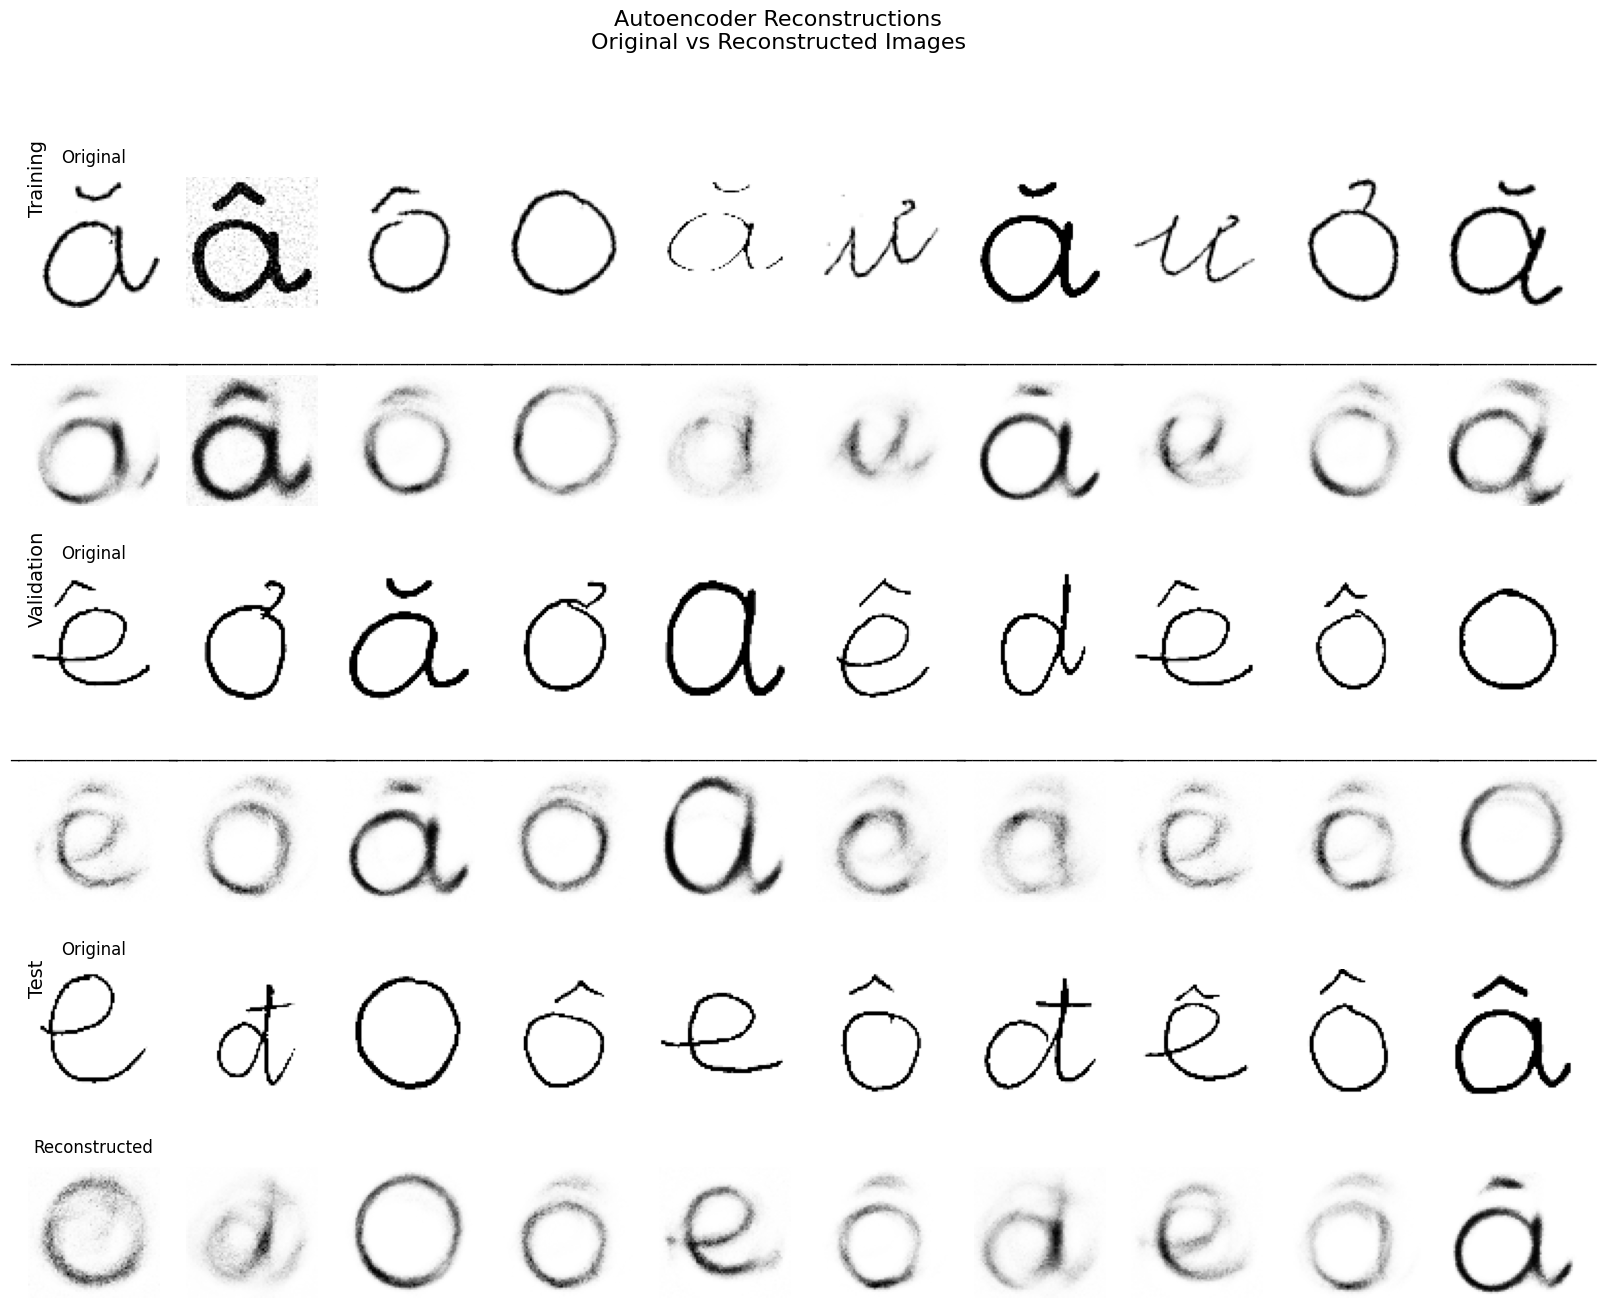

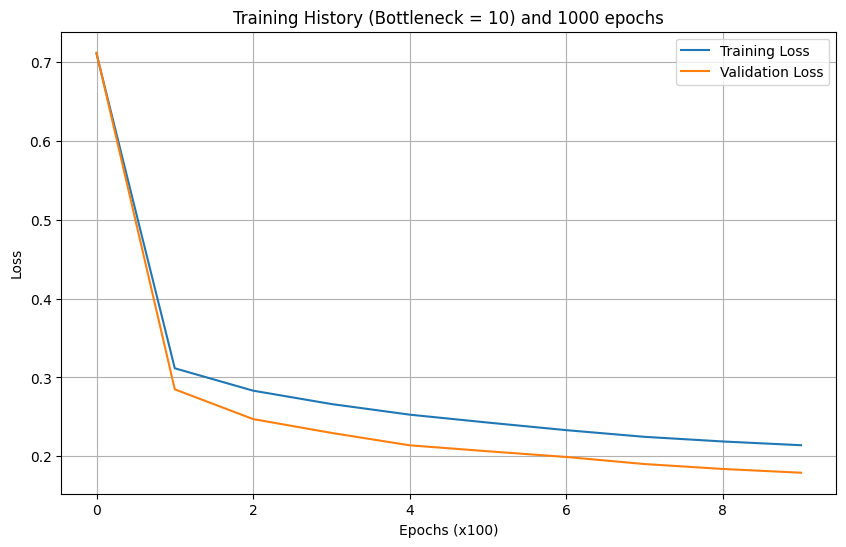

In [9]:
best_params = main(X_train, X_val, X_test)

In [10]:
# Model Architecture Definition
def initialize_parameters():
    """
    Initialize the autoencoder parameters with proper scaling.
    Uses He initialization for ReLU layers.
    """
    input_dim = 4096  # 64x64 images
    hidden_dim = 64
    bottleneck_dim = 2
    output_dim = input_dim

    params = {
        "layer_1": {
            "W": np.random.normal(size=(input_dim, hidden_dim)) * np.sqrt(2.0/input_dim),
            "b": np.zeros(shape=(hidden_dim,)),
        },
        "layer_2": {
            "W": np.random.normal(size=(hidden_dim, hidden_dim)) * np.sqrt(2.0/hidden_dim),
            "b": np.zeros(shape=(hidden_dim,)),
        },
        "layer_3": {
            "W": np.random.normal(size=(hidden_dim, bottleneck_dim)) * np.sqrt(2.0/hidden_dim),
            "b": np.zeros(shape=(bottleneck_dim,)),
        },
        "layer_4": {
            "W": np.random.normal(size=(bottleneck_dim, hidden_dim)) * np.sqrt(2.0/bottleneck_dim),
            "b": np.zeros(shape=(hidden_dim,)),
        },
        "layer_5": {
            "W": np.random.normal(size=(hidden_dim, output_dim)) * np.sqrt(2.0/hidden_dim),
            "b": np.zeros(shape=(output_dim,)),
        },
    }
    return params

def predict_fn(params, X):
    """
    Forward pass through the autoencoder.
    Returns both the reconstruction and the bottleneck representation.
    """
    X0 = X
    # Encoder
    X1 = jax.nn.relu(X0 @ params["layer_1"]["W"] + params["layer_1"]["b"])
    X2 = jax.nn.relu(X1 @ params["layer_2"]["W"] + params["layer_2"]["b"])
    X3 = X2 @ params["layer_3"]["W"] + params["layer_3"]["b"]  # Bottleneck layer
    # Decoder
    X4 = jax.nn.relu(X3 @ params["layer_4"]["W"] + params["layer_4"]["b"])
    X5 = jax.nn.sigmoid(X4 @ params["layer_5"]["W"] + params["layer_5"]["b"])
    return {'reconstruct': X5, 'bottleneck': X3}

def loss_fn(params, X):
    """
    Binary cross-entropy loss with numerical stability improvements.
    """
    reconstruct_X = predict_fn(params, X)['reconstruct']
    eps = 1e-7  # Small constant for numerical stability
    reconstruct_X = jnp.clip(reconstruct_X, eps, 1 - eps)
    loss = -(X * jnp.log(reconstruct_X) + (1 - X) * jnp.log(1 - reconstruct_X))
    return jnp.mean(loss)

def train_autoencoder(X_train, X_val, params, num_epochs=100, batch_size=32, learning_rate=1e-3):
    """
    Training loop with validation monitoring and early stopping.
    """
    # Initialize optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    # Prepare for training
    grad_loss_fn = jax.grad(loss_fn)
    grad_loss_fn = jax.jit(grad_loss_fn)

    # Training monitoring
    best_val_loss = float('inf')
    best_params = None
    train_losses = []
    val_losses = []

    for i in range(num_epochs):
        # Get random batch
        idxs = np.random.randint(low=0, high=X_train.shape[0], size=batch_size)
        x_batch = X_train[idxs]

        # Compute gradients and update parameters
        grad = grad_loss_fn(params, x_batch)
        update, opt_state = optimizer.update(grad, opt_state)
        params = optax.apply_updates(params, update)

        # Monitor progress every 100 steps
        if i % 100 == 0:
            train_loss = loss_fn(params, X_train)
            val_loss = loss_fn(params, X_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Step: {i}")
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = jax.tree_map(lambda x: x.copy(), params)

    return best_params, train_losses, val_losses

def visualize_results(params, X_train, X_val, X_test, num_examples=10):
    """
    Create visualization of reconstruction results from all three datasets.
    For each dataset, shows original images on top and their reconstructions below.
    """

    # Each set will have 2 rows (original and reconstruction) and num_examples columns
    fig, axes = plt.subplots(6, num_examples, figsize=(20, 15))
    titles = ['Training', 'Validation', 'Test']
    datasets = [X_train, X_val, X_test]

    for dataset_idx, (title, data) in enumerate(zip(titles, datasets)):
        # Calculate the row indices for this dataset
        # Each dataset gets 2 rows: originals (row 0) and reconstructions (row 1)
        row_orig = dataset_idx * 2
        row_recon = row_orig + 1

        # Add dataset title
        plt.text(-0.5, (row_orig + 0.5), title,
                rotation=90, fontsize=14, va='center',
                transform=axes[row_orig, 0].transData)

        # Generate random indices for this dataset
        example_indices = np.random.randint(0, len(data), size=num_examples)

        for col, idx in enumerate(example_indices):
            # Get original image and its reconstruction
            original = data[idx]
            reconstructed = predict_fn(params, original.reshape(1, -1))['reconstruct'][0]

            # Plot original image on top row
            axes[row_orig, col].imshow(original.reshape(64, 64), cmap='Greys')
            axes[row_orig, col].axis('off')
            if col == 0:
                axes[row_orig, col].set_title('Original', pad=10)

            # Plot reconstruction on bottom row
            axes[row_recon, col].imshow(reconstructed.reshape(64, 64), cmap='Greys')
            axes[row_recon, col].axis('off')
            if col == 0:
                axes[row_recon, col].set_title('Reconstructed', pad=10)

        # Add a bit of space between datasets
        if dataset_idx < 2:
            for col in range(num_examples):
                axes[row_recon, col].set_title('_' * 20, pad=10)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0.02, 0, 1, 0.95])
    plt.suptitle('Autoencoder Reconstructions\nOriginal vs Reconstructed Images',
                fontsize=16, y=0.98)

    plt.show()

def plot_training_history(train_losses, val_losses):
    """
    Plot training and validation loss curves.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs (x100)')
    plt.ylabel('Loss')
    plt.title('Training History (Bottleneck = 2) and 1000 epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def main(X_train, X_val, X_test):
    # Prepare data
    X_train, X_val, X_test = X_train.to_numpy(), X_val.to_numpy(), X_test.to_numpy()

    # Initialize model
    params = initialize_parameters()

    # Train model
    best_params, train_losses, val_losses = train_autoencoder(
        X_train,
        X_val,
        params,
        num_epochs=1000,
        batch_size=32,
        learning_rate=1e-3
    )

    # Evaluate on test set
    test_loss = loss_fn(best_params, X_test)
    print(f"\nFinal Test Loss: {test_loss:.4f}")

    # Visualize results
    visualize_results(best_params, X_train, X_val, X_test)
    plot_training_history(train_losses, val_losses)

Step: 0
Training Loss: 0.7303
Validation Loss: 0.7310


<ipython-input-45-96edc9857ed4>:103: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 100
Training Loss: 0.3118
Validation Loss: 0.2896


<ipython-input-45-96edc9857ed4>:103: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 200
Training Loss: 0.2951
Validation Loss: 0.2679


<ipython-input-45-96edc9857ed4>:103: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 300
Training Loss: 0.2769
Validation Loss: 0.2429


<ipython-input-45-96edc9857ed4>:103: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 400
Training Loss: 0.2712
Validation Loss: 0.2379


<ipython-input-45-96edc9857ed4>:103: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 500
Training Loss: 0.2674
Validation Loss: 0.2336


<ipython-input-45-96edc9857ed4>:103: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 600
Training Loss: 0.2652
Validation Loss: 0.2313


<ipython-input-45-96edc9857ed4>:103: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 700
Training Loss: 0.2636
Validation Loss: 0.2292


<ipython-input-45-96edc9857ed4>:103: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 800
Training Loss: 0.2627
Validation Loss: 0.2275


<ipython-input-45-96edc9857ed4>:103: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)


Step: 900
Training Loss: 0.2619
Validation Loss: 0.2266


<ipython-input-45-96edc9857ed4>:103: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x.copy(), params)



Final Test Loss: 0.2232


<ipython-input-45-96edc9857ed4>:155: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0.02, 0, 1, 0.95])


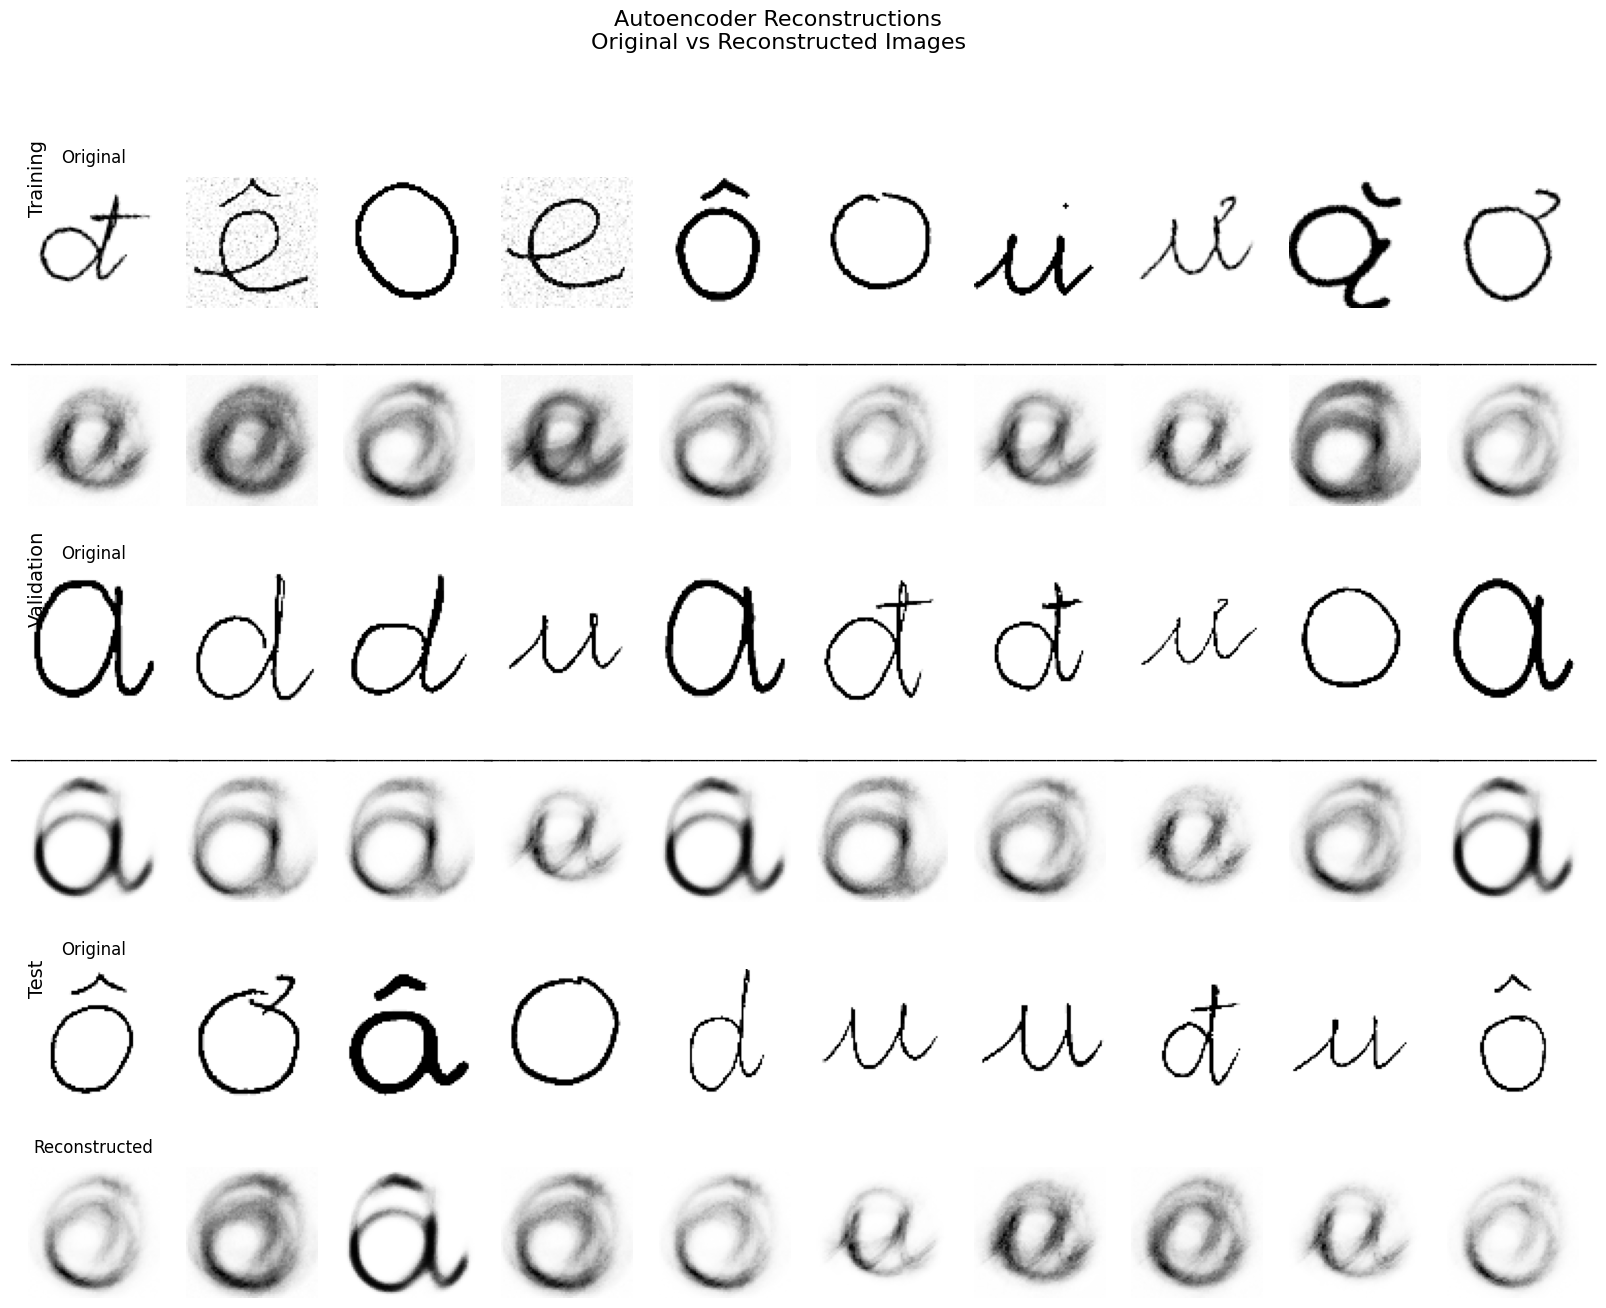

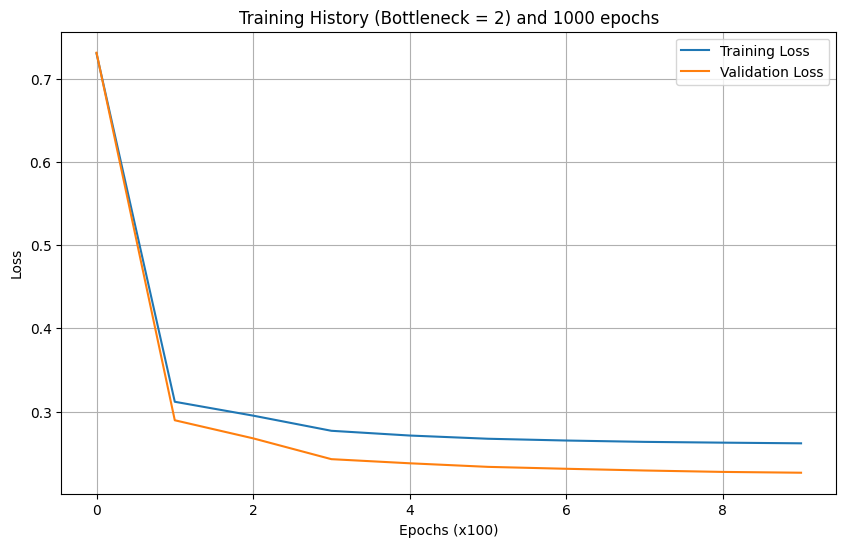

In [ ]:
main(X_train, X_val, X_test)